In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl
import matplotlib.patches as patches

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
ml = 0.5
regions = {
'equatorial' : [(-5,0),(-78.25+ml, -73.75)],
'transition' : [(-8,-5), (-77.25+ml, -72.75)],
'central' : [(-12,-8), (-75.5+ml, -71.0)],
'southern' : [(-18,-15),  (-66.25+ml, -61.75)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def read(region):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+region+'_cross_15UTC_1985-2018_peru_v2.nc'
    
    ds = xr.open_dataset(inpath)
    ds_filtered = ds.where(ds['z']>topo)
    
    return ds_filtered

In [7]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [8]:
tcw = readERA('tcwv')['tcwv']

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/tcwv_15UTC_1981-2019_peru_big.nc


In [9]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = tir.where(height<1400)

In [10]:
precip = readERA('rain')['tp'].where(height>2000)

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/rain_15UTC_1981-2019_peru_big.nc


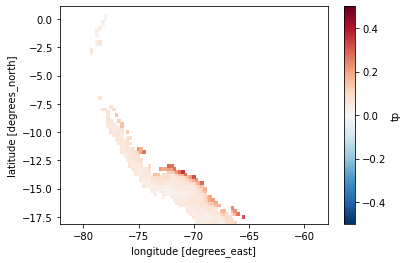

In [11]:
dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/central_dw_spellDates_0.15perc_v2.p", "rb"))
wds = dwspells['wet5']
xy, x_ind, y_ind  = np.intersect1d(wds, precip.time, return_indices=True)
wds = wds[x_ind]
precip_w = precip.sel(time=wds).mean('time')-precip.mean('time').where(height>3500)
(precip_w*1000).plot(vmax=0.5, cmap='RdBu_r')

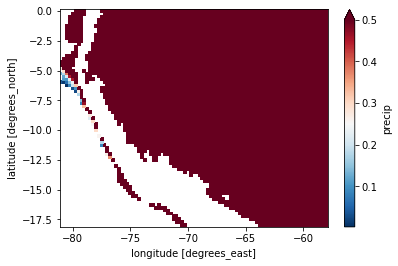

In [12]:
dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/central_dw_spellDates_0.15perc_v2.p", "rb"))
wds = dwspells['wet5']
xy, x_ind, y_ind  = np.intersect1d(wds, tir.time, return_indices=True)
wds = wds[x_ind]
precip_c = tir.sel(time=wds).mean('time')
(precip_c).plot(vmax=0.5, cmap='RdBu_r')

In [13]:
def apply_drywet(ds, precip, region, spell=3, minus='0days', plus='0days', area=0.2):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2_perPix_split.p", "rb"))  #for crosssection
    dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    print('dry', len(dds), 'wet', len(wds))
    xy, x_ind, y_ind  = np.intersect1d(dds, precip.time, return_indices=True)
    dds = dds[x_ind]
    xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, precip.time, return_indices=True)
    wds = wds[x_ind]
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    print('dry2', len(dds), 'wet2', len(wds))
    
    if (minus=='0days') & (plus=='0days'):
        alls = regions[region]
        precip_d = precip.sel(time=dds) # filter for 1000 precip
        precip_w = precip.sel(time=wds)

        mean_dry = ds.sel(time=dds).where(precip_d*1000 < 1).mean('time')
        mean_wet = ds.sel(time=wds).where(precip_w*1000 < 1).mean('time')
    else:
        mean_dry = ds.sel(time=dds).mean('time')
        mean_wet = ds.sel(time=wds).mean('time')
        
#     all_dry = ds.sel(time=dds)
#     all_wet = ds.sel(time=wds)
    
#     ## clims
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     xyd, x_indd, y_indd = np.intersect1d(ds['time.dayofyear'].values,dds.dayofyear.values, return_indices=True)
#     xyw, x_indw, y_indw = np.intersect1d(ds ['time.dayofyear'].values,wds.dayofyear.values, return_indices=True)
    
#     #ipdb.set_trace()
#     wdays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in wds.dayofyear.values:
#             wdays.append(dst.time.values)
#     ddays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in dds.dayofyear.values:
#             ddays.append(dst.time.values)
#     #ipdb.set_trace()
#     doy_dryclim_all = ds.sel(time=ddays)
#     doy_wetclim_all = ds.sel(time=wdays)
#     #
#     mean_clim = ds.mean('time')

#     doy_dryclim_all = ds.sel(time=ds['time.dayofyear'].isin(dds.dayofyear))
#     doy_wetclim_all = ds.sel(time=ds['time.dayofyear'].isin(wds.dayofyear))
    
#     doy_dryclim = doy_dryclim_all.mean('time')
#     doy_wetclim = doy_dryclim_all.mean('time')
    
    #mean_clim = ds.mean('time')
    
    
#     for dat in [mean_dry, mean_wet, doy_dryclim, doy_wetclim, mean_clim]:
#         dat = calc_from_era(dat)
    
    
    outdic = {'dry' : mean_dry,
              'wet' : mean_wet,
#               'dry_ttest' : all_dry,
#               'wet_ttest' : all_wet,
#               'dry_doyclim' : doy_dryclim,
#               'wet_doyclim' : doy_wetclim,
#               'mean_clim' : mean_clim,
#               'all_clim' : ds
             }
#               'dry_doyclim_ttest' : doy_dryclim_all,
#               'wet_doyclim_ttest' : doy_wetclim_all}
    
    return outdic

In [14]:
ar = 0.15
spelldays = 7

In [15]:
def get_series(reg_tag):
    
    #crossection
    ds_filtered = read(reg_tag)
    
    alls = regions[reg_tag]
    tcwr = tcw.sel(latitude=slice(alls[0][0], alls[0][1])).mean(['latitude'])
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean(['latitude'])
    precipr = precip.sel(latitude=slice(alls[0][0], alls[0][1])).where(hei>2000).mean(['latitude', 'longitude']) #era precip

    series = []
    for num in np.arange(0,5)[::-1]:
        series.append(apply_drywet(ds_filtered, precipr, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
    for num in np.arange(1,6):
        series.append(apply_drywet(ds_filtered, precipr, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))
        
    series_tcw = []
    series_pr = []


    for num in np.arange(0,5)[::-1]:
        series_tcw.append(apply_drywet(tcwr, precipr, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
    for num in np.arange(1,6):
        series_tcw.append(apply_drywet(tcwr, precipr, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))
        
    for num in np.arange(0,5)[::-1]:
        series_pr.append(apply_drywet(precipr,precipr, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
    for num in np.arange(1,6):
        series_pr.append(apply_drywet(precipr,precipr, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))
        
    series_precip = []    
    pr = tir.sel(latitude=slice(alls[0][0], alls[0][1])).mean(['latitude'])  #chirps
    for num in np.arange(0,5)[::-1]:
        series_precip.append(apply_drywet(pr,precipr, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
    for num in np.arange(1,6):
        series_precip.append(apply_drywet(pr,precipr, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))
        
    test = []
    testtcw = []
    testq = []
    testv = []
    testu = []
    testulow = []
    testvlow = []
    testwlow = []
    testd = []
    testprecip = []
    testprecip_e = []
    for ids in np.arange(len(series)):

        mask = np.isnan(series[ids]['wet'].sel(level=750)['q'])
        
        #mask = height > 3000#np.isfinite(series_precip[ids]['wet'])
        
        
        if reg_tag == 'transition':
            hh = 2000
        else:
            hh = 2500
        test.append(series[ids]['wet'].where(hei>hh).sel(level=600).mean(['longitude'])['w'].values)                                         #series[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
       # ipdb.set_trace()
        testtcw.append(series_tcw[ids]['wet'].sel(longitude=slice(alls[1][0],alls[1][1])).mean(['longitude']).values)
        testprecip_e.append(series_pr[ids]['wet'].values)
        if reg_tag in ['central', 'equatorial', 'transition']:
            qlev=950
        else:
            qlev=850
        
        testu.append(series[ids]['wet'].sel(level=200, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
        testulow.append(series[ids]['wet'].sel(level=qlev, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
        testvlow.append(series[ids]['wet'].sel(level=qlev, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['v'].values)
        testq.append(series[ids]['wet'].sel(level=qlev, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)

        testwlow.append(series[ids]['wet'].sel(level=slice(300,600), longitude=slice(alls[1][0],alls[1][1])).min(['level','longitude'])['w'].values)
        testd.append(series[ids]['wet'].sel(level=200).where(mask).mean(['longitude'])['d'].values)
        #testprecip.append(series_precip[ids]['wet'].mean(['longitude']).values) #chirps
        testprecip.append(series_precip[ids]['wet'].sel(longitude=slice(alls[1][0],alls[1][1])).mean(['longitude']).values)
        
        
    return {'q_low' : testq,
            'w_up' : test,
            'tcw_low' : testtcw,
            'u_up' : testu,
            'div_up' : testd,
            'v_mid' : testvlow,
            'u_mid' : testulow,
            'w_mid' : testwlow,
            'prcp' : testprecip,
            'prcp_e' : testprecip_e
           }

In [16]:
central_dic = get_series('central')

dry 198 wet 169
dry2 181 wet2 169
dry 198 wet 169
dry2 184 wet2 169
dry 198 wet 169
dry2 185 wet2 169
dry 198 wet 169
dry2 186 wet2 169
dry 198 wet 169
dry2 187 wet2 168
dry 198 wet 169
dry2 189 wet2 169
dry 198 wet 169
dry2 190 wet2 169
dry 198 wet 169
dry2 189 wet2 169
dry 198 wet 169
dry2 188 wet2 169
dry 198 wet 169
dry2 188 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 169
dry2 198 wet2 169
dry 198 wet 16

In [17]:
equatorial_dic = get_series('equatorial')

dry 495 wet 132
dry2 491 wet2 132
dry 495 wet 132
dry2 491 wet2 131
dry 495 wet 132
dry2 490 wet2 132
dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 490 wet2 132
dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 489 wet2 131
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 132
dry2 495 wet2 132
dry 495 wet 13

In [18]:
transition_dic = get_series('transition')

dry 497 wet 144
dry2 484 wet2 144
dry 497 wet 144
dry2 493 wet2 144
dry 497 wet 144
dry2 493 wet2 144
dry 497 wet 144
dry2 493 wet2 144
dry 497 wet 144
dry2 494 wet2 144
dry 497 wet 144
dry2 494 wet2 144
dry 497 wet 144
dry2 494 wet2 144
dry 497 wet 144
dry2 494 wet2 143
dry 497 wet 144
dry2 495 wet2 143
dry 497 wet 144
dry2 495 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 496 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 144
dry2 497 wet2 144
dry 497 wet 14

In [19]:
southern_dic = get_series('southern')

dry 87 wet 52
dry2 77 wet2 51
dry 87 wet 52
dry2 78 wet2 51
dry 87 wet 52
dry2 79 wet2 50
dry 87 wet 52
dry2 79 wet2 50
dry 87 wet 52
dry2 80 wet2 51
dry 87 wet 52
dry2 78 wet2 51
dry 87 wet 52
dry2 78 wet2 51
dry 87 wet 52
dry2 79 wet2 51
dry 87 wet 52
dry2 81 wet2 51
dry 87 wet 52
dry2 82 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 52
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet 52
dry2 87 wet2 51
dry 87 wet

In [20]:
cmap = plt.get_cmap("tab10")

In [21]:
cmap(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [22]:
# for rr, sdic in zip(['equatorial', 'transition', 'central', 'southern'], (equatorial_dic, transition_dic, central_dic, southern_dic)):
#     pkl.dump(sdic, open('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+rr+'_timeseries_fig2_qTCWlag.p', 'wb'))

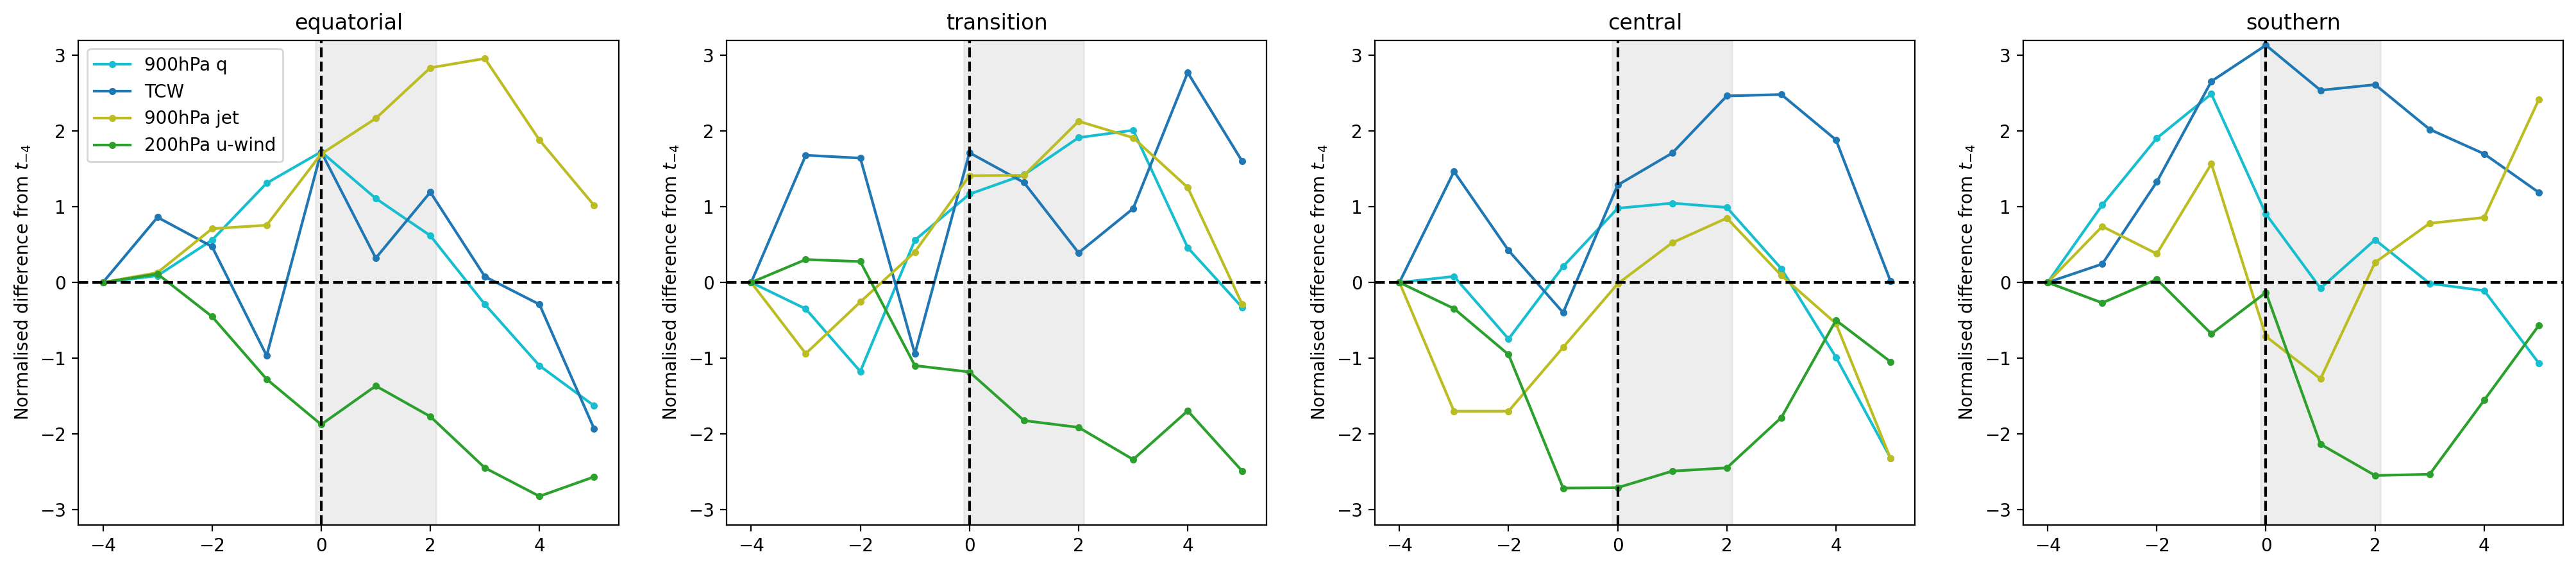

In [24]:
regtag = ['equatorial', 'transition', 'central', 'southern']
dics = [equatorial_dic, transition_dic, central_dic, southern_dic]
f = plt.figure(figsize=(25,5), dpi=200)

mind = 0


for ids, dic in enumerate(dics):
    
    
    ax = f.add_subplot(1,4,ids+1)
    qq = (dic['q_low']-dic['q_low'][mind])/ np.std(dic['q_low'])
    ws = np.sqrt(np.array(dic['u_mid'])**2 + np.array(dic['v_mid'])**2)
    ws = (ws-ws[mind])/ np.std(ws)
    tt = (dic['tcw_low']-dic['tcw_low'][mind])/ np.std(dic['tcw_low'])
    
#     if ids == 1:
#         qq[1::] = qq[1::]+1
#         ws[1::] = ws[1::]+1
#     if ids == 3:
#         tt[2:4] = tt[2:4]-1.2
        
    ax.plot(np.arange(len(dic['u_up']))-4,qq, marker='o', label='900hPa q', ms=3, color=cmap(9))
    ax.plot(np.arange(len(dic['u_up']))-4, tt, label='TCW', marker='o', ms=3, color=cmap(0))
    #ax.plot((dic['tcw_up']-dic['tcw_up'][mind])/ np.std(dic['tcw_up']), label='tcw_up', marker='o')
    #ax.plot((dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='prcp', marker='o')
    
    #ax.plot(np.arange(len(dic['prcp']))-4,(dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='Prcp', marker='o', ms=3, color='k')
    #ax.plot(np.arange(len(dic['prcp_e']))-4,(dic['prcp_e']-dic['prcp_e'][mind])/ np.std(dic['prcp_e']), label='Prcp_e', marker='o', ms=3, color='brown')
    #ax.plot(np.arange(len(dic['w_mid']))-4,(dic['w_up']-dic['w_up'][mind])/ np.std(dic['w_up']), label='w_mid', marker='o', ms=3, color='brown')
    
    
    
    
    

#     if regtag[ids] == 'southern':
#         ax.plot((dic['u_mid']-dic['u_mid'][mind])/ np.std(dic['u_mid']-dic['u_mid'][mind]), label='jet', marker='o')
#     else:
#         ax.plot(((dic['v_mid']-dic['v_mid'][mind])/ np.std(dic['v_mid']-dic['v_mid'][mind])), label='jet', marker='o')
    ax.plot(np.arange(len(dic['u_up']))-4, ws, label='900hPa jet', marker='o', ms=3, color=cmap(8))
    #ax2 = ax.twinx()
    ax.plot(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind])/ np.std((dic['u_up'])), color=cmap(2), marker='o', ms=3, label='200hPa u-wind')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(0, color='k', linestyle='dashed')
    ax.axhline(0, color='k', linestyle='dashed')
    ax.set_ylim(-3.2,3.2)
    
    bottom, top = ax.get_ylim()
    ax.add_patch(patches.Rectangle((-0.1, bottom),2.2, top-bottom, color='lightgrey', alpha=0.4, zorder=0, edgecolor=None))
#     ax.axvline(4+5, color='k', linestyle='dashed')
    ax.set_ylabel(r'Normalised difference from $t_{-4}$')

  
   # ax2.set_ylim(-4,4)
    if ids == 0:
        ax.legend(loc='upper left')
    plt.title(regtag[ids])

In [ ]:
regtag = ['equatorial', 'transition', 'central', 'southern']
dics = [equatorial_dic, transition_dic, central_dic, southern_dic]
f = plt.figure(figsize=(25,5), dpi=200)

mind = 0


for ids, dic in enumerate(dics):
    
    
    ax = f.add_subplot(1,4,ids+1)
    qq = (dic['q_low']-dic['q_low'][mind])/ np.std(dic['q_low'])
    ws = np.sqrt(np.array(dic['u_mid'])**2 + np.array(dic['v_mid'])**2)
    ws = (ws-ws[mind])/ np.std(ws)
    tt = (dic['tcw_low']-dic['tcw_low'][mind])/ np.std(dic['tcw_low'])
    
#     if ids == 1:
#         qq[1::] = qq[1::]+1
#         ws[1::] = ws[1::]+1
#     if ids == 3:
#         tt[2:4] = tt[2:4]-1.2
        
    ax.plot(np.arange(len(dic['u_up']))-4,qq, marker='o', label='900hPa q', ms=3, color=cmap(9))
    ax.plot(np.arange(len(dic['u_up']))-4, tt, label='TCW', marker='o', ms=3, color=cmap(0))
    #ax.plot((dic['tcw_up']-dic['tcw_up'][mind])/ np.std(dic['tcw_up']), label='tcw_up', marker='o')
    #ax.plot((dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='prcp', marker='o')
    
    #ax.plot(np.arange(len(dic['prcp']))-4,(dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='Prcp', marker='o', ms=3, color='k')
    #ax.plot(np.arange(len(dic['prcp_e']))-4,(dic['prcp_e']-dic['prcp_e'][mind])/ np.std(dic['prcp_e']), label='Prcp_e', marker='o', ms=3, color='brown')
    #ax.plot(np.arange(len(dic['w_mid']))-4,(dic['w_up']-dic['w_up'][mind])/ np.std(dic['w_up']), label='w_mid', marker='o', ms=3, color='brown')
    
    
    
    
    

#     if regtag[ids] == 'southern':
#         ax.plot((dic['u_mid']-dic['u_mid'][mind])/ np.std(dic['u_mid']-dic['u_mid'][mind]), label='jet', marker='o')
#     else:
#         ax.plot(((dic['v_mid']-dic['v_mid'][mind])/ np.std(dic['v_mid']-dic['v_mid'][mind])), label='jet', marker='o')
    ax.plot(np.arange(len(dic['u_up']))-4, ws, label='900hPa jet', marker='o', ms=3, color=cmap(8))
    #ax2 = ax.twinx()
    ax.plot(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind])/ np.std((dic['u_up'])), color=cmap(2), marker='o', ms=3, label='200hPa u-wind')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(0, color='k', linestyle='dashed')
    ax.axhline(0, color='k', linestyle='dashed')
    ax.set_ylim(-3.2,3.2)
    
    bottom, top = ax.get_ylim()
    ax.add_patch(patches.Rectangle((-0.1, bottom),2.2, top-bottom, color='lightgrey', alpha=0.4, zorder=0, edgecolor=None))
#     ax.axvline(4+5, color='k', linestyle='dashed')
    ax.set_ylabel(r'Normalised difference from $t_{-4}$')

  
   # ax2.set_ylim(-4,4)
    if ids == 0:
        ax.legend(loc='upper left')
    plt.title(regtag[ids])

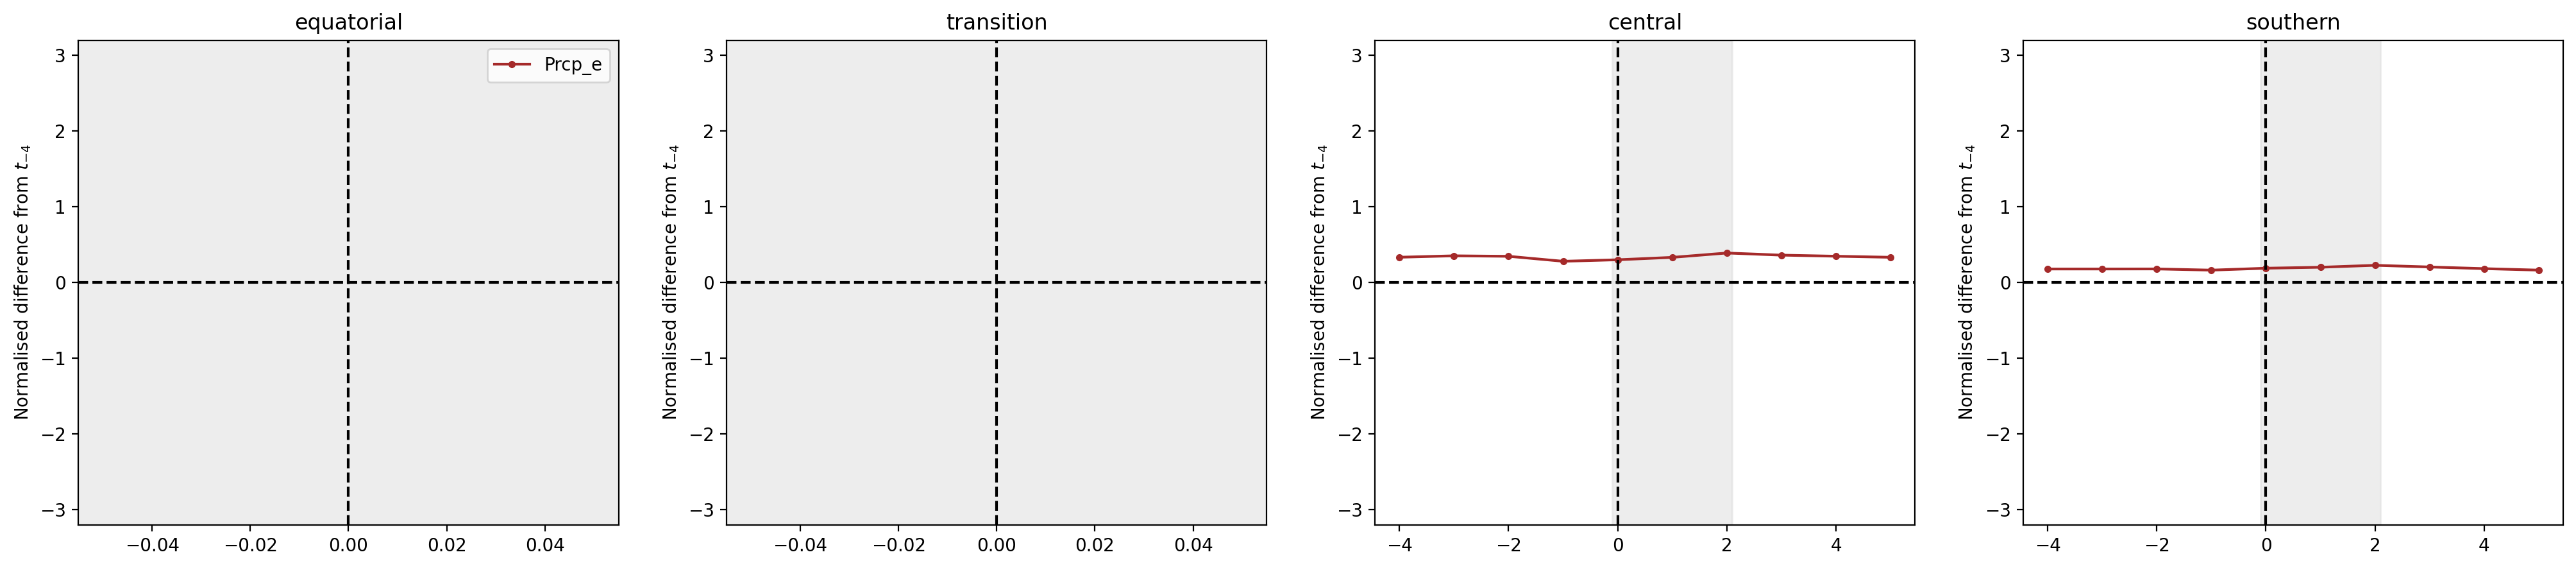

In [24]:
regtag = ['equatorial', 'transition', 'central', 'southern']
dics = [equatorial_dic, transition_dic, central_dic, southern_dic]
f = plt.figure(figsize=(25,5), dpi=200)

mind = 0


for ids, dic in enumerate(dics):
    ax = f.add_subplot(1,4,ids+1)

    #ax.plot(np.arange(len(dic['u_up']))-4,(dic['q_low']-dic['q_low'][mind])/ np.std(dic['q_low']), marker='o', label='850hPa q', ms=3, color=cmap(9))
    #ax.plot(np.arange(len(dic['u_up']))-4,(dic['tcw_low']-dic['tcw_low'][mind])/ np.std(dic['tcw_low']), label='TCW', marker='o', ms=3, color=cmap(0))
    #ax.plot((dic['tcw_up']-dic['tcw_up'][mind])/ np.std(dic['tcw_up']), label='tcw_up', marker='o')
    #ax.plot((dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='prcp', marker='o')
    
    #ax.plot(np.arange(len(dic['prcp']))-4,(dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='Prcp', marker='o', ms=3, color='k')
    ax.plot(np.arange(len(dic['prcp_e']))-4,np.array(dic['prcp_e'])*1000, label='Prcp_e', marker='o', ms=3, color='brown')
    
    
    ws = np.sqrt(np.array(dic['u_mid'])**2 + np.array(dic['v_mid'])**2)
    
    

#     if regtag[ids] == 'southern':
#         ax.plot((dic['u_mid']-dic['u_mid'][mind])/ np.std(dic['u_mid']-dic['u_mid'][mind]), label='jet', marker='o')
#     else:
#         ax.plot(((dic['v_mid']-dic['v_mid'][mind])/ np.std(dic['v_mid']-dic['v_mid'][mind])), label='jet', marker='o')
#     ax.plot(np.arange(len(dic['u_up']))-4,(ws-ws[mind])/ np.std(ws), label='850hPa jet', marker='o', ms=3, color=cmap(8))
#     #ax2 = ax.twinx()
#     ax.plot(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind])/ np.std((dic['u_up'])), color=cmap(2), marker='o', ms=3, label='200hPa zonal wind')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(0, color='k', linestyle='dashed')
    ax.axhline(0, color='k', linestyle='dashed')
    ax.set_ylim(-3.2,3.2)
    
    bottom, top = ax.get_ylim()
    ax.add_patch(patches.Rectangle((-0.1, bottom),2.2, top-bottom, color='lightgrey', alpha=0.4, zorder=0, edgecolor=None))
#     ax.axvline(4+5, color='k', linestyle='dashed')
    ax.set_ylabel(r'Normalised difference from $t_{-4}$')

  
   # ax2.set_ylim(-4,4)
    if ids == 0:
        ax.legend()
    plt.title(regtag[ids])

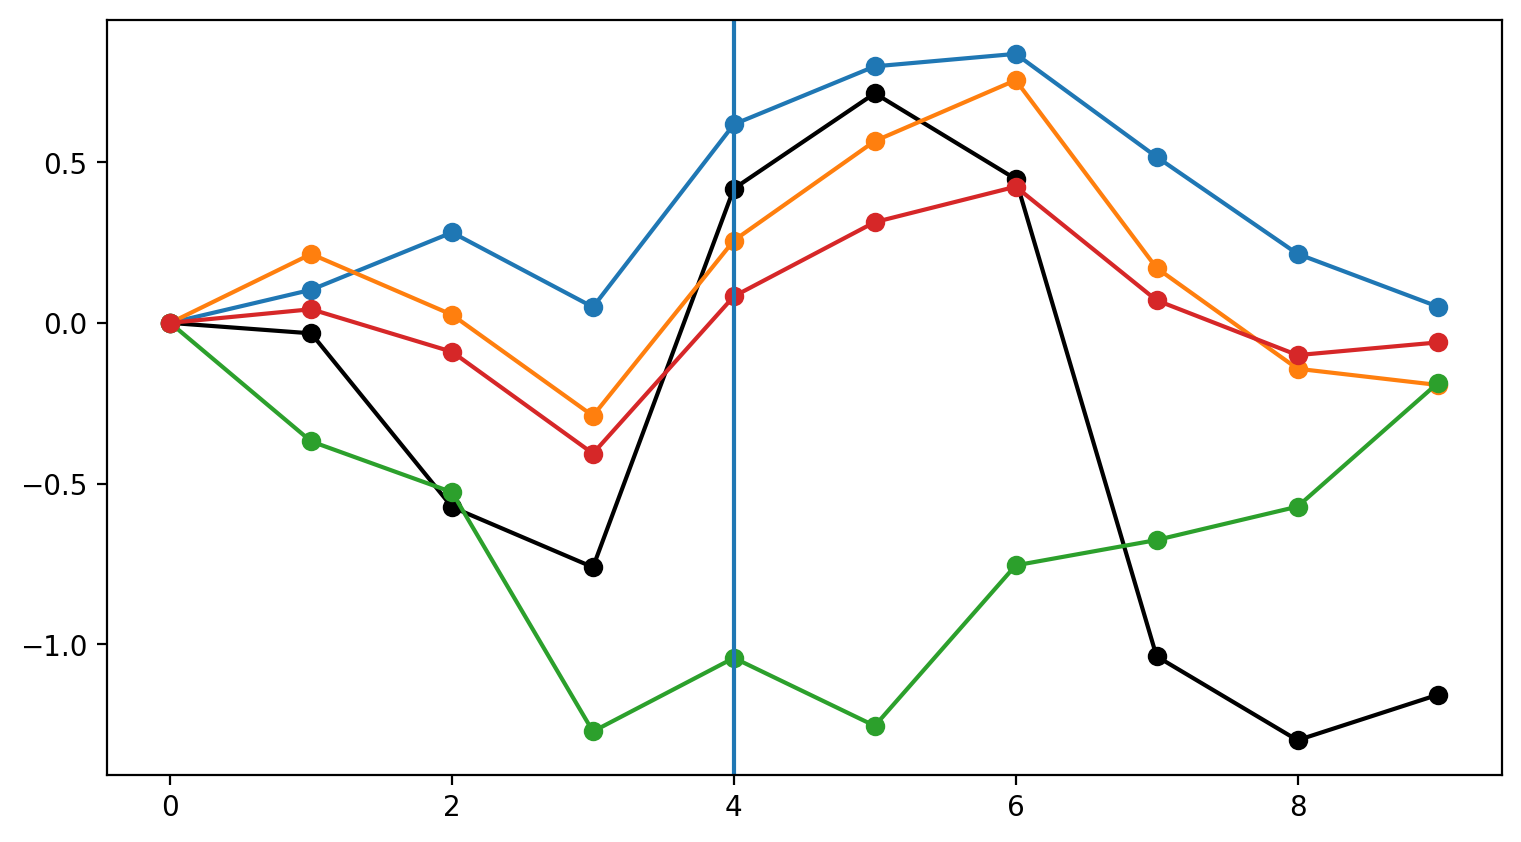

In [71]:
f=plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
plt.plot((central_dic['tcw_up']-central_dic['tcw_up'][0]), marker='o')
plt.plot((central_dic['q_low']-central_dic['q_low'][0])*10000, marker='o', color='k')
plt.plot((central_dic['tcw_low']-central_dic['tcw_low'][0]), marker='o')
plt.plot((central_dic['u_up']-central_dic['u_up'][0]), marker='o')
plt.plot((central_dic['div_up']-central_dic['div_up'][0])*100000, marker='o')
ax.axvline(4)

In [34]:
#crossection
reg_tag = 'central'
ds_filtered = read(reg_tag)

series = []
for num in np.arange(0,5)[::-1]:
    series.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 597 wet 714
dry2 568 wet2 707
dry 597 wet 714
dry2 570 wet2 708
dry 597 wet 714
dry2 572 wet2 709
dry 597 wet 714
dry2 574 wet2 711
dry 597 wet 714
dry2 575 wet2 712
dry 597 wet 714
dry2 577 wet2 712
dry 597 wet 714
dry2 579 wet2 712
dry 597 wet 714
dry2 579 wet2 712
dry 597 wet 714
dry2 579 wet2 712
dry 597 wet 714
dry2 578 wet2 711


In [52]:
#tcwv
reg_tag = 'central'

series_tcw = []
alls = regions[reg_tag]
tcwr = tcw.sel(latitude=slice(alls[0][0], alls[0][1])).mean(['latitude'])

for num in np.arange(0,5)[::-1]:
    series_tcw.append(apply_drywet(tcwr, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series_tcw.append(apply_drywet(tcwr, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714
dry 597 wet 714
dry2 597 wet2 714


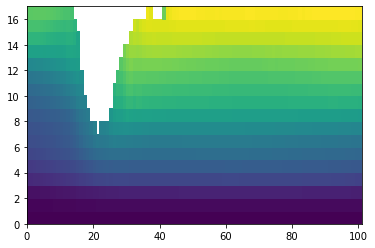

In [61]:
plt.pcolormesh(series[0]['wet']['q'])

In [64]:
test = []
testq = []
testv = []
testu = []
testd = []
for ids in np.arange(len(series)):
    
    mask = np.isnan(series[ids]['wet'].sel(level=750)['q'])

    test.append(series_tcw[ids]['wet'].where(mask).mean(['longitude']).values)                                         #series[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
    #testq.append(series_tcw[ids]['wet'].sel(longitude=slice(alls[1][0],alls[1][1])).mean(['longitude']).values)
    testq.append(series[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
    testv.append(series[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['v'].values*-1)
    testu.append(series[ids]['wet'].sel(level=200, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
    testd.append(series[ids]['wet'].sel(level=200).where(mask).mean(['longitude'])['d'].values)

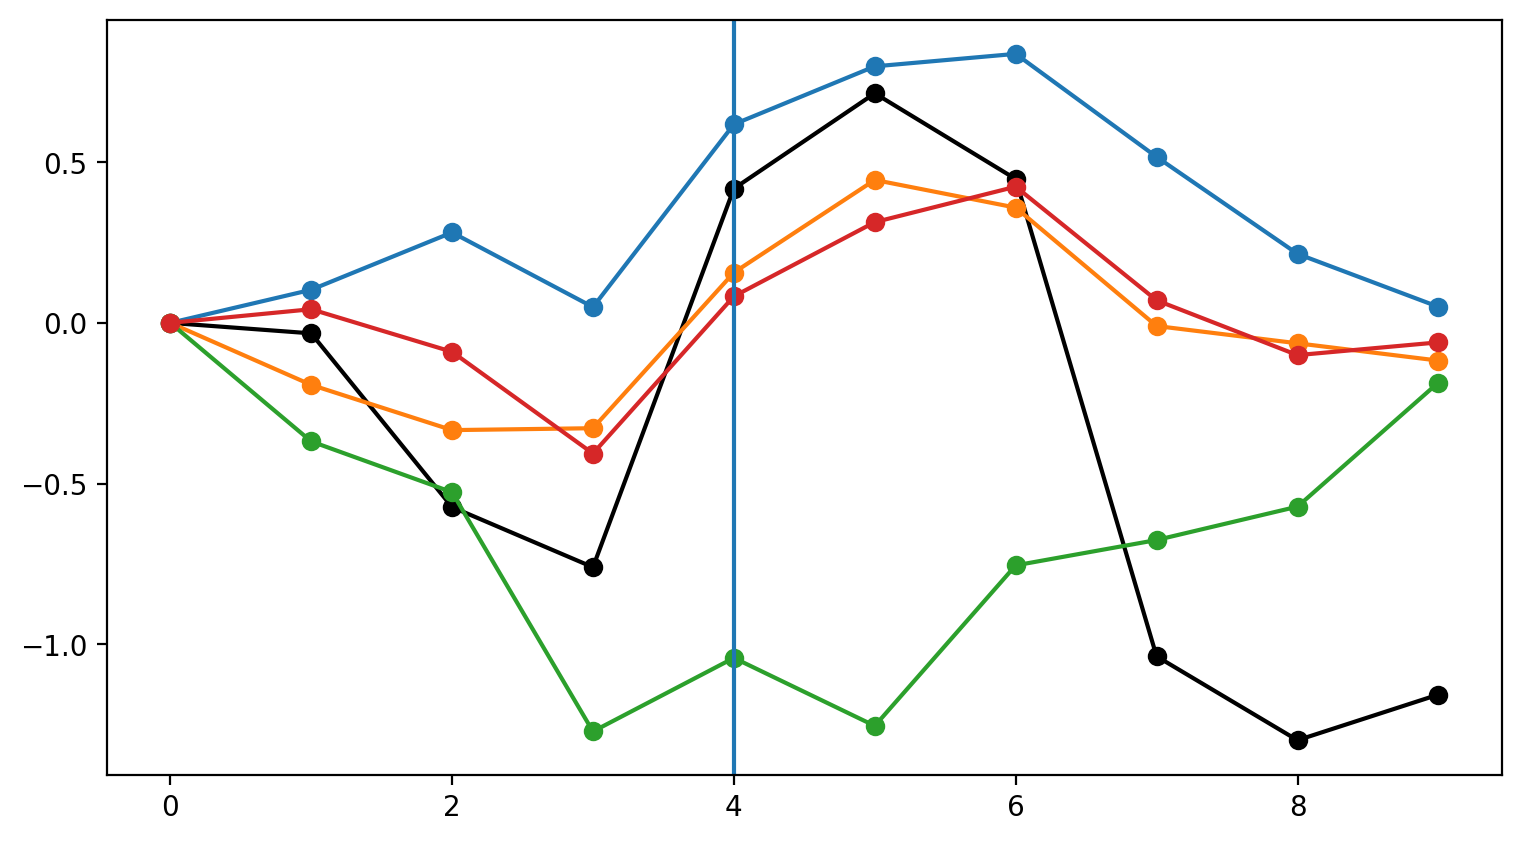

In [65]:
f=plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
plt.plot((test-test[0]), marker='o')
plt.plot((testq-testq[0])*10000, marker='o', color='k')
plt.plot((testv-testv[0]), marker='o')
plt.plot((testu-testu[0]), marker='o')
plt.plot((testd-testd[0])*100000, marker='o')
ax.axvline(4)

In [39]:
#crossection
reg_tag = 'southern'
ds_filtered = read(reg_tag)

series_so = []
for num in np.arange(0,5)[::-1]:
    series_so.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series_so.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 271 wet 216
dry2 259 wet2 213
dry 271 wet 216
dry2 260 wet2 213
dry 271 wet 216
dry2 258 wet2 212
dry 271 wet 216
dry2 257 wet2 212
dry 271 wet 216
dry2 257 wet2 213
dry 271 wet 216
dry2 257 wet2 214
dry 271 wet 216
dry2 260 wet2 214
dry 271 wet 216
dry2 260 wet2 214
dry 271 wet 216
dry2 260 wet2 214
dry 271 wet 216
dry2 260 wet2 213


In [40]:
#tcwv
reg_tag = 'southern'

series_tcw_so = []
alls = regions[reg_tag]
tcwso = tcw.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1])).mean(['longitude','latitude'])

for num in np.arange(0,5)[::-1]:
    series_tcw_so.append(apply_drywet(tcwso, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series_tcw_so.append(apply_drywet(tcwso, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 271 wet 216
dry2 271 wet2 215
dry 271 wet 216
dry2 271 wet2 215
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216
dry 271 wet 216
dry2 271 wet2 216


In [41]:
tests = []
testqs = []
testvs = []
testus = []
testds = []
for ids in np.arange(len(series_so)):
    
    mask = np.isnan(series_so[ids]['wet'].sel(level=850)['q'])

    tests.append(series_so[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
    testqs.append(series_tcw_so[ids]['wet'].values)
    testvs.append(series_so[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['v'].values*-1)
    testus.append(series_so[ids]['wet'].sel(level=200, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
    testds.append(series_so[ids]['wet'].sel(level=200).where(mask).mean(['longitude'])['d'].values)

In [45]:
#crossection
reg_tag = 'transition'
ds_filtered = read(reg_tag)

series_so = []
for num in np.arange(0,5)[::-1]:
    series_so.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series_so.append(apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 1002 wet 650
dry2 990 wet2 650
dry 1002 wet 650
dry2 999 wet2 650
dry 1002 wet 650
dry2 999 wet2 648
dry 1002 wet 650
dry2 999 wet2 650
dry 1002 wet 650
dry2 1000 wet2 650
dry 1002 wet 650
dry2 999 wet2 650
dry 1002 wet 650
dry2 1000 wet2 650
dry 1002 wet 650
dry2 1000 wet2 649
dry 1002 wet 650
dry2 1001 wet2 648
dry 1002 wet 650
dry2 1001 wet2 649


In [46]:
#tcwv
reg_tag = 'transition'

series_tcw_so = []
alls = regions[reg_tag]
tcwso = tcw.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1])).mean(['longitude','latitude'])

for num in np.arange(0,5)[::-1]:
    series_tcw_so.append(apply_drywet(tcwso, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series_tcw_so.append(apply_drywet(tcwso, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 1002 wet 650
dry2 1002 wet2 650
dry 1002 wet 650
dry2 1002 wet2 649
dry 1002 wet 650
dry2 1002 wet2 648
dry 1002 wet 650
dry2 1002 wet2 649
dry 1002 wet 650
dry2 1002 wet2 650
dry 1002 wet 650
dry2 1002 wet2 650
dry 1002 wet 650
dry2 1002 wet2 650
dry 1002 wet 650
dry2 1001 wet2 650
dry 1002 wet 650
dry2 1000 wet2 650
dry 1002 wet 650
dry2 1001 wet2 650


In [47]:
testt = []
testqt = []
testvt = []
testut = []
testdt = []
for ids in np.arange(len(series_so)):
    
    mask = np.isnan(series_so[ids]['wet'].sel(level=850)['q'])

    testt.append(series_so[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
    testqt.append(series_tcw_so[ids]['wet'].values)
    testvt.append(series_so[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['v'].values*-1)
    testut.append(series_so[ids]['wet'].sel(level=200, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
    testdt.append(series_so[ids]['wet'].sel(level=200).where(mask).mean(['longitude'])['d'].values)

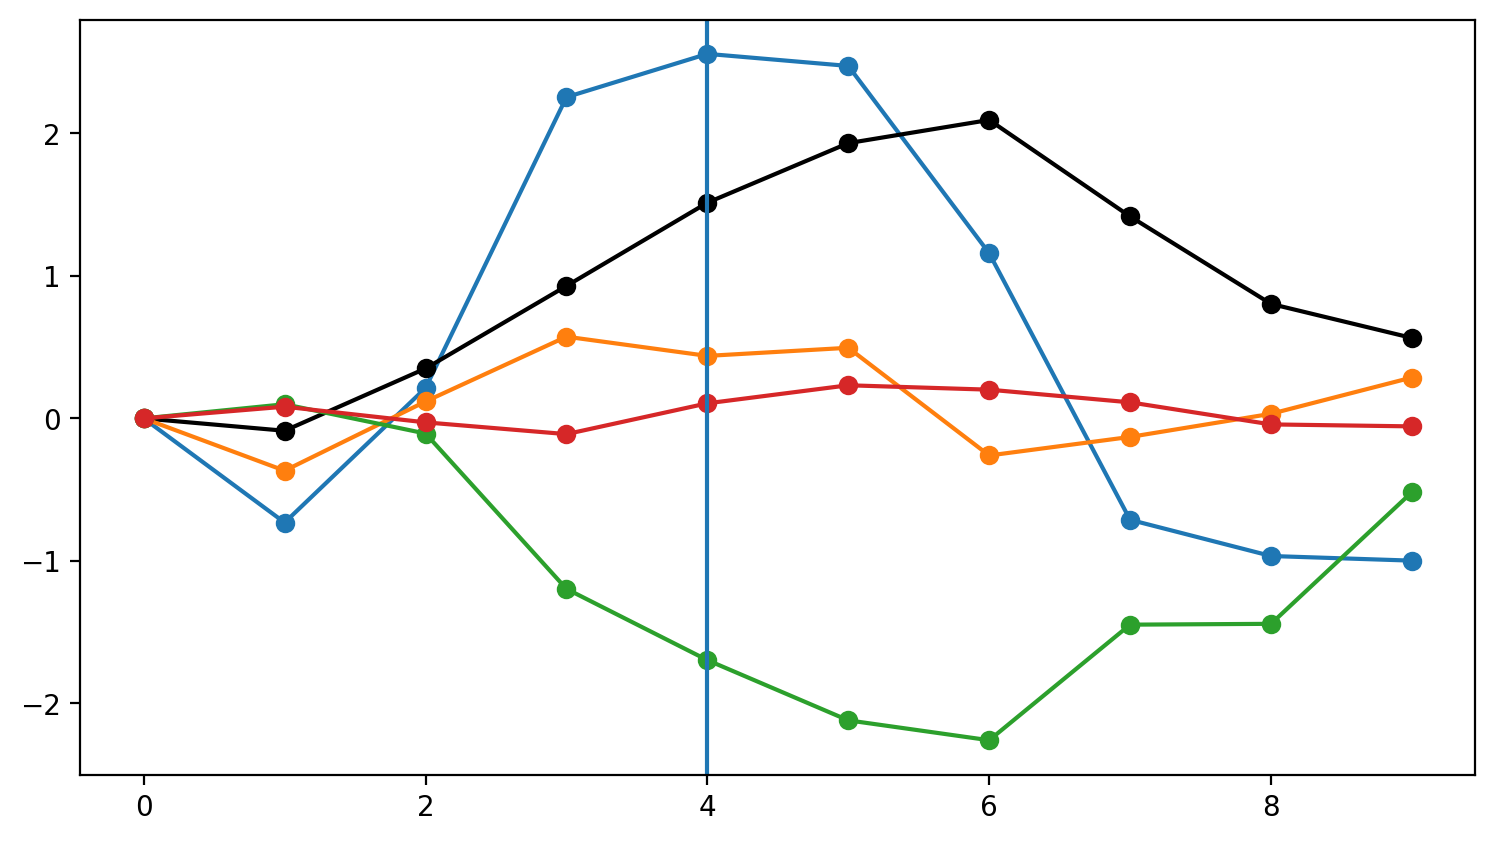

In [42]:
f=plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
plt.plot((tests-tests[0])*10000, marker='o')
plt.plot((testqs-testqs[0]), marker='o', color='k')
plt.plot((testvs-testvs[0]), marker='o')
plt.plot((testus-testus[0]), marker='o')
plt.plot((testds-testds[0])*100000, marker='o')
ax.axvline(4)

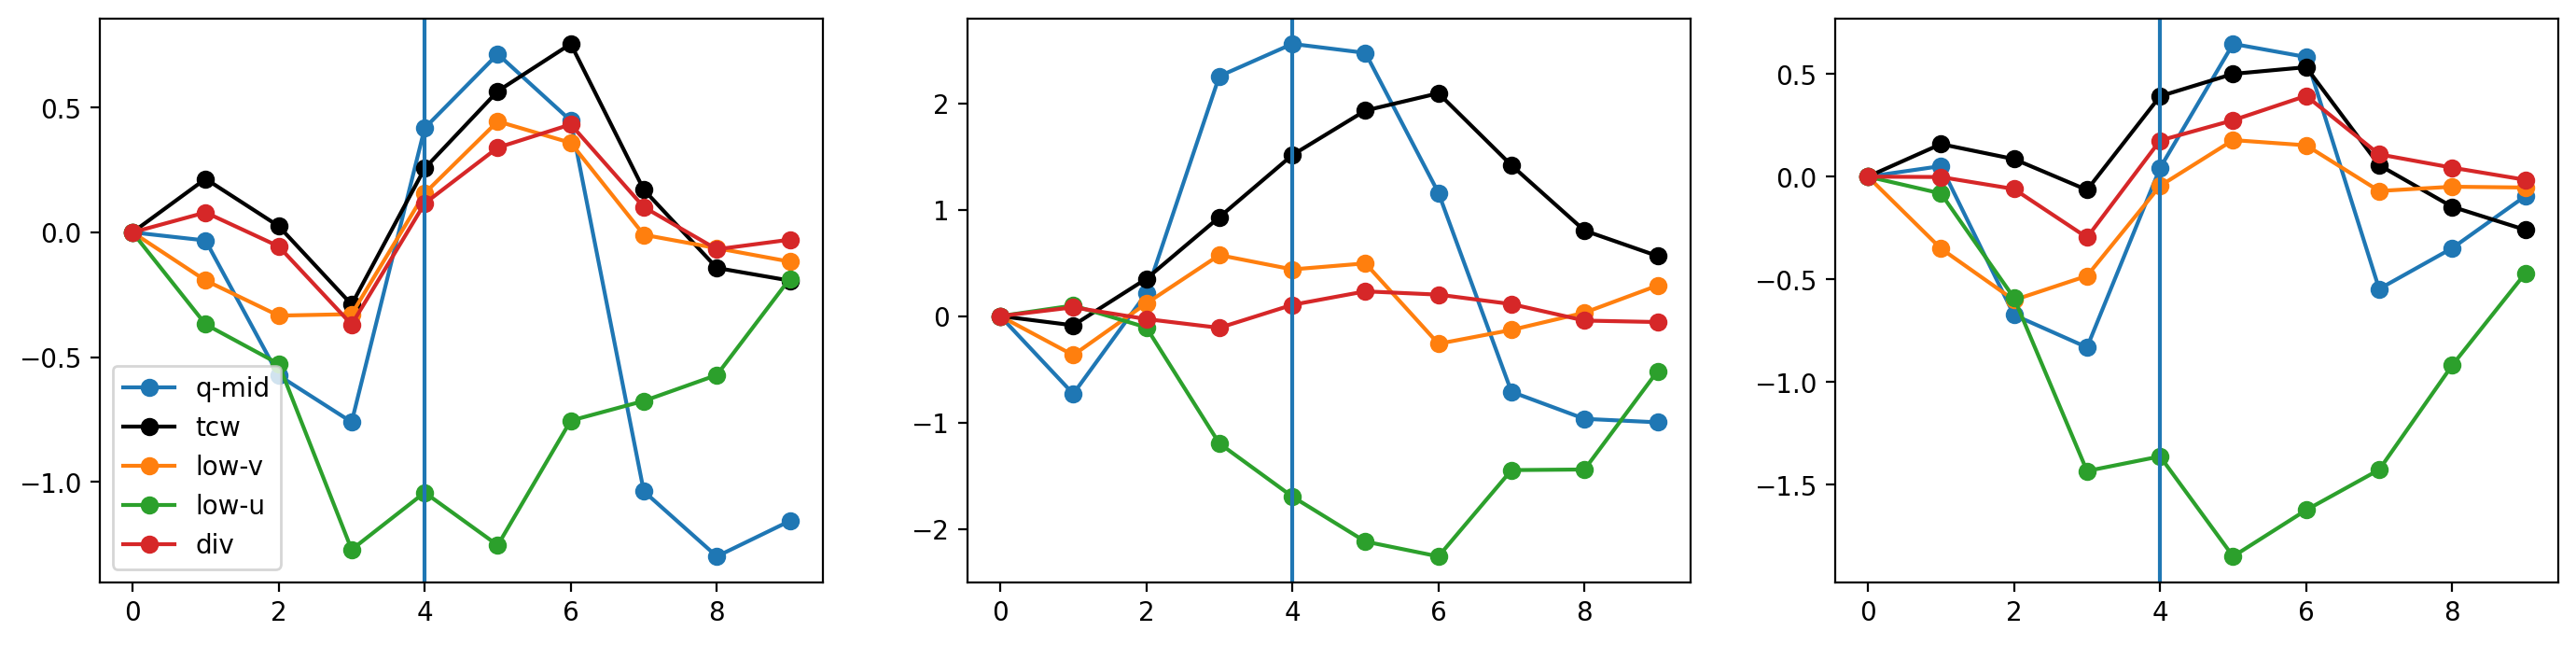

In [51]:
f=plt.figure(figsize=(17,4), dpi=200)
ax = f.add_subplot(131)
plt.plot((test-test[0])*10000, marker='o', label='q-mid')
plt.plot((testq-testq[0]), marker='o', color='k', label='tcw')
plt.plot((testv-testv[0]), marker='o', label='low-v')
plt.plot((testu-testu[0]), marker='o', label='low-u')
#plt.plot((testd-testd[0])*100000, marker='o', label='div')
ax.axvline(4)
plt.legend()
ax = f.add_subplot(132)
plt.plot((tests-tests[0])*10000, marker='o')
plt.plot((testqs-testqs[0]), marker='o', color='k')
plt.plot((testvs-testvs[0]), marker='o')
plt.plot((testus-testus[0]), marker='o')
#plt.plot((testds-testds[0])*100000, marker='o')
ax.axvline(4)
ax = f.add_subplot(133)
plt.plot((testt-testt[0])*10000, marker='o')
plt.plot((testqt-testqt[0]), marker='o', color='k')
plt.plot((testvt-testvt[0]), marker='o')
plt.plot((testut-testut[0]), marker='o')
#plt.plot((testdt-testdt[0])*100000, marker='o')
ax.axvline(4)

In [ ]:
regtag = ['equatorial', 'central', 'southern']
f = plt.figure(figsize=(18,5), dpi=200)

ind = 8+5

for ids, ps in enumerate(qlow_l):
    ax = f.add_subplot(1,3,ids+1)
    
    tc = tcw_l[ids]
    uw = u_l[ids]
    
    ax.plot(np.arange(len(uw[5::8])),(ps[5::8]-ps.isel(times=5)).values/ np.std((ps[5::8]-ps.isel(times=5)).values),  label='qlow', marker='o')
    ax.plot(np.arange(len(uw[5::8])),(tc[5::8]-tc.isel(times=5)).values/ np.std((tc[5::8]-tc.isel(times=5)).values), label='tcw', marker='o')
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(uw[5::8])),(uw[5::8]-uw.isel(times=5)).values/ np.std((uw[5::8]-uw.isel(times=5)).values), color='k', marker='o')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(4, color='k', linestyle='dashed')
    ax.axvline(4+5, color='k', linestyle='dashed')

    ax.set_ylim(-3,3)
    ax2.set_ylim(-4,4)
ax.legend()